In [6]:
import arviz as az
import pandas as pd

In [7]:
import os.path as op
from risk_experiment.cogmodels.fit_model import build_model, get_data
bids_folder = '/data/ds-risk'

In [8]:
model_label = 'neural3'
session = '3t2'
bids_folder = '/data/ds-risk'
roi = 'npcr'

In [9]:
data = get_data('neural3', session, bids_folder, roi)

100%|██████████| 30/30 [00:01<00:00, 20.04it/s]


In [10]:
model = build_model(model_label, data, roi)

In [11]:
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'ses-3t2_model-neural3_trace.netcdf'))

In [12]:
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)
ppc.loc[ppc.index.get_level_values('risky_first')] = 1 - ppc.loc[ppc.index.get_level_values('risky_first')]
# "Chose risky" vs "chose 2nd option coding"

In [13]:
rnp = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'gamma_rnp_simple.tsv'), sep='\t', index_col=[0,1], dtype={'subject':str})[['rnp']]
rnp['risk_preference'] = (rnp['rnp'] > 0.55).map({True:'risk seeking', False:'risk averse'})

ppc = ppc.set_index(ppc.join(rnp)['risk_preference'], append=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/3158488709.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ppc = ppc.set_index(ppc.join(rnp)['risk_preference'], append=True)


In [14]:
data = data.join(rnp)

In [15]:
from risk_experiment.cogmodels.utils import summarize_ppc, plot_prediction

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:236: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/1178149432.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summary = summary.join(data.groupby(['Order', 'n_safe', 'median_split(sd)', 'risk_preference']).mean()['chose_risky'])


                                                              hdi025    hdi975
Order       n_safe median_split(sd)        risk_preference                    
Risky first 5.0    High neural uncertainty risk averse      0.581974  0.649988
                                           risk seeking     0.542160  0.612487
                   Low neural uncertainty  risk averse      0.548005  0.625268
                                           risk seeking     0.585135  0.646086
            7.0    High neural uncertainty risk averse      0.462631  0.528561
                                           risk seeking     0.538228  0.595016
                   Low neural uncertainty  risk averse      0.514225  0.578016
                                           risk seeking     0.527039  0.577111
            10.0   High neural uncertainty risk averse      0.394818  0.449214
                                           risk seeking     0.486678  0.535847
                   Low neural uncertainty  risk aver

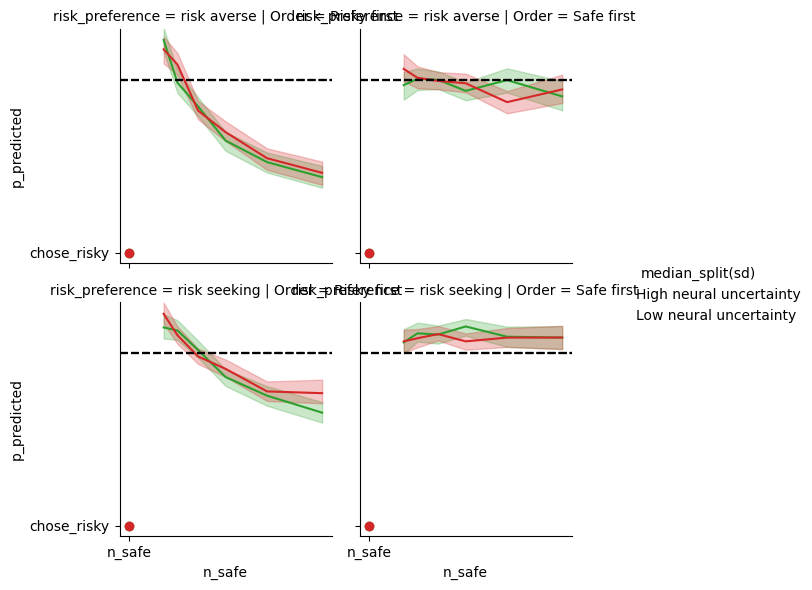

In [17]:
tmp = ppc.loc['p'].groupby(['subject', 'Order', 'n_safe', 'median_split(sd)', 'risk_preference']).mean()

summary = summarize_ppc(tmp, groupby=['Order', 'n_safe', 'median_split(sd)', 'risk_preference'])
summary = summary.join(data.groupby(['Order', 'n_safe', 'median_split(sd)', 'risk_preference']).mean()['chose_risky'])

fac = sns.FacetGrid(summary.reset_index(), col='Order', row='risk_preference', hue='median_split(sd)',
                                                 palette=sns.color_palette()[2:],)

fac.map_dataframe(plot_prediction, x='n_safe', y='p_predicted')
plt.tight_layout()
fac.add_legend()
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
fac.map(plt.scatter, x='n_safe', y='chose_risky')
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/1495862042.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',


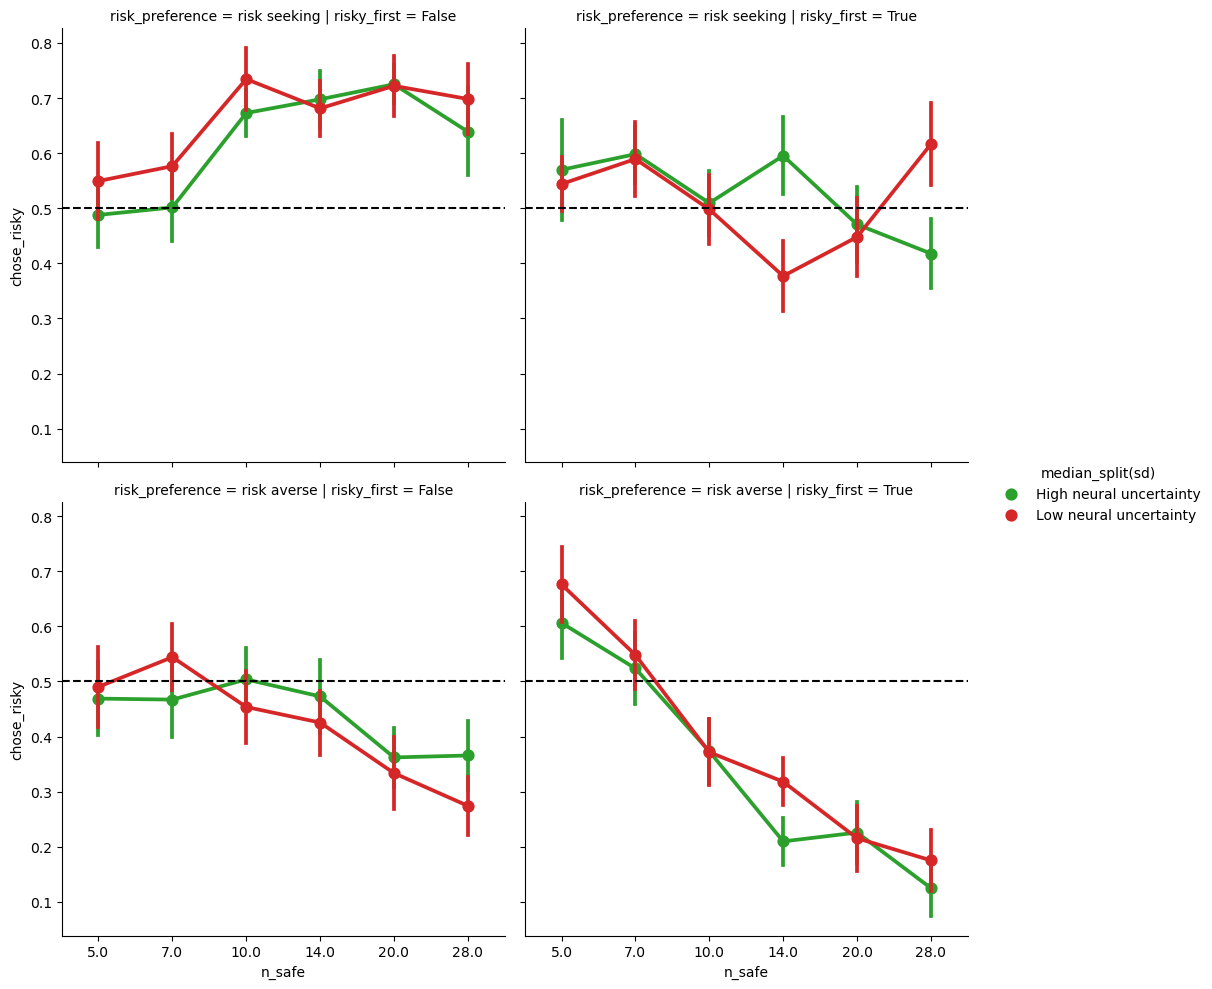

In [18]:
# fac = sns.FacetGrr
fac = sns.catplot(x='n_safe', data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(), y='chose_risky', hue='median_split(sd)',  row='risk_preference', kind='point', col='risky_first',
                  palette=sns.color_palette()[2:], errorbar='se')
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))



/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_46104/4017671789.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fac = sns.FacetGrid(data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(),


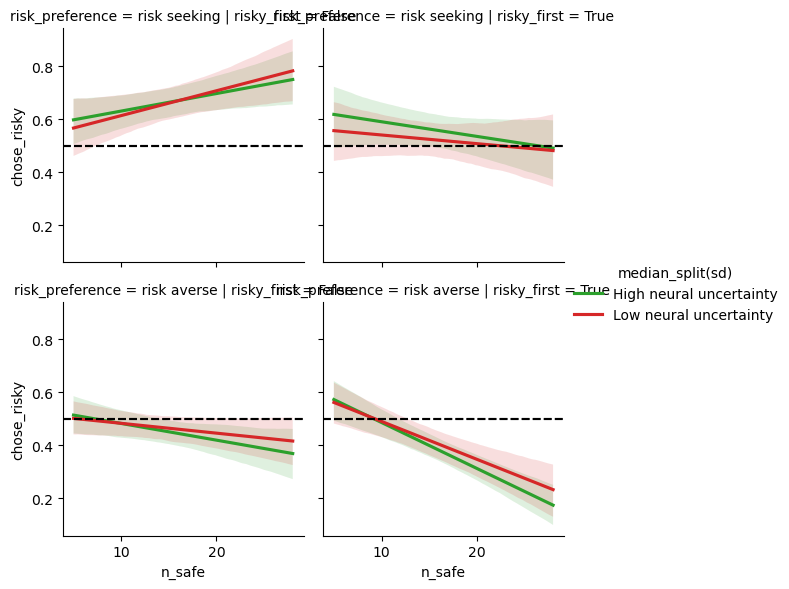

In [40]:
fac = sns.FacetGrid(data=data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean().reset_index(),
                    hue='median_split(sd)',  row='risk_preference', col='risky_first',
                  palette=sns.color_palette()[2:])
fac.map(sns.regplot, 'n_safe', 'chose_risky', scatter=False)
fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'), scatter=False)
fac.add_legend()


In [19]:
import bambi

In [103]:
tmp = data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/1714503577.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby(['subject', 'risk_preference', 'risky_first', 'n_safe', 'median_split(sd)']).mean()


In [104]:
tmp['neural_noise'] = tmp.index.get_level_values('median_split(sd)')

In [46]:
model = bambi.Model('chose_risky ~ n_safe*neural_noise*risk_preference*risky_first + (1|subject)', data=tmp.reset_index())
idata = model.fit()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


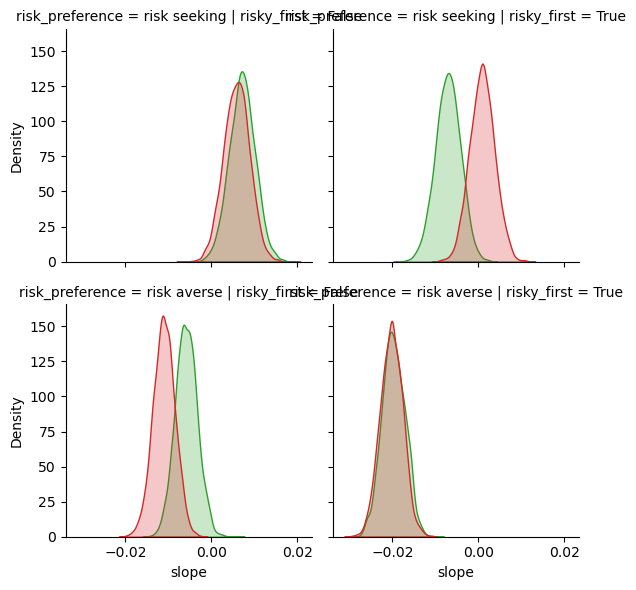

In [105]:
permutations = [[0, 1],
                tmp.index.get_level_values('risk_preference').unique(),
                tmp['neural_noise'].unique(),
                tmp.index.get_level_values('risky_first').unique()
                 ]
names = ['n_safe', 'risk_preference', 'neural_noise', 'risky_first']
fake_data = pd.MultiIndex.from_product(permutations, names=names).to_frame().reset_index(drop=True)
pred = model.predict(idata, 'mean', fake_data, inplace=False, include_group_specific=False)['posterior']['chose_risky_mean']
pred = pred.to_dataframe().unstack([0, 1])
pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))
intercept = pred.xs(0, 0, 'n_safe')
slope = pred.xs(1, 0, 'n_safe') - intercept
slope = slope.droplevel(0, axis=1).stack([0, 1]).to_frame('slope')


fac = sns.FacetGrid(slope.reset_index(), col='risky_first', hue='neural_noise', row='risk_preference', palette=sns.color_palette()[2:])
fac.map(sns.kdeplot, 'slope', fill=True)

In [100]:
tmp = slope.loc[('risk averse', 'High neural uncertainty', False), :] - slope.loc[('risk averse', 'Low neural uncertainty', False), :]
(tmp > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/2114197104.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp = slope.loc[('risk averse', 'High neural uncertainty', False), :] - slope.loc[('risk averse', 'Low neural uncertainty', False), :]


slope    0.9265
dtype: float64

In [101]:
tmp = slope.loc[('risk seeking', 'High neural uncertainty', True), :] - slope.loc[('risk seeking', 'Low neural uncertainty', True), :]
(tmp > 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/2758599739.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp = slope.loc[('risk seeking', 'High neural uncertainty', True), :] - slope.loc[('risk seeking', 'Low neural uncertainty', True), :]


slope    0.02525
dtype: float64

In [65]:
pred['posterior']['chose_risky_mean'].to_dataframe()

chose_risky_mean
chain draw chose_risky_obs                  
0     0    0                        0.583517
           1                        0.639466
           2                        0.691210
           3                        0.578271
           4                        0.486814
...                                      ...
3     999  11                       0.514617
           12                       0.539504
           13                       0.610161
           14                       0.547972
           15                       0.634269

[64000 rows x 1 columns]

In [55]:
permutations

[[0, 1],
 Index(['risk seeking', 'risk averse'], dtype='object', name='risk_preference')]

In [47]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.524,0.052,0.427,0.618,0.002,0.001,919.0,1533.0,1.00
n_safe,-0.006,0.003,-0.011,-0.001,0.000,0.000,970.0,1829.0,1.00
neural_noise[Low neural uncertainty],0.052,0.057,-0.064,0.152,0.002,0.001,898.0,2007.0,1.00
n_safe:neural_noise[Low neural uncertainty],-0.005,0.004,-0.012,0.001,0.000,0.000,884.0,1984.0,1.00
risk_preference[risk seeking],-0.002,0.079,-0.147,0.147,0.003,0.002,873.0,1658.0,1.00
n_safe:risk_preference[risk seeking],0.013,0.004,0.006,0.020,0.000,0.000,933.0,1959.0,1.00
"neural_noise:risk_preference[Low neural uncertainty, risk seeking]",0.006,0.088,-0.162,0.172,0.003,0.002,936.0,1760.0,1.00
"n_safe:neural_noise:risk_preference[Low neural uncertainty, risk seeking]",0.004,0.005,-0.007,0.014,0.000,0.000,836.0,1849.0,1.00
risky_first,0.098,0.060,-0.009,0.216,0.002,0.001,801.0,2075.0,1.01
n_safe:risky_first,-0.014,0.004,-0.021,-0.007,0.000,0.000,823.0,1948.0,1.00


In [50]:
model.predict(idata,)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [43]:
# x1 = idata.posterior['n_safe'].to_dataframe()
# x2 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:neural_noise'].to_dataframe().values
# x3 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:risk_preference'].to_dataframe().values
# x4 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:neural_noise'].to_dataframe().values + idata.posterior['n_safe:risk_preference'].to_dataframe().values + idata.posterior['n_safe:neural_noise:risk_preference'].to_dataframe().values

# x1 = idata.posterior['n_safe'].to_dataframe()
# x2 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:neural_noise'].to_dataframe().values
# x3 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:risk_preference'].to_dataframe().values
# x4 = idata.posterior['n_safe'].to_dataframe() +  idata.posterior['n_safe:neural_noise'].to_dataframe().values

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/931462509.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_47112/931462509.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2)


<Axes: ylabel='Density'>

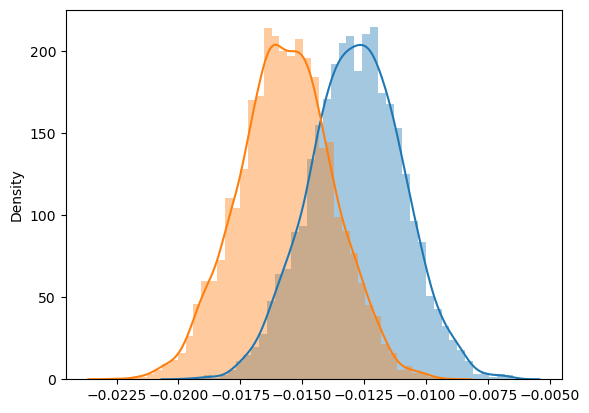

In [45]:
sns.distplot(x1)
sns.distplot(x2)

In [ ]:
model_label = 'neural3'
session = '7t2'
bids_folder = '/data/ds-risk'
roi = 'npcr'

In [2]:
import arviz as az

In [4]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/ses-3t2_model-2_trace.netcdf')

In [10]:
import seaborn as sns

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98088/955809873.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x.xs('risky_first[T.True]',0, -1))


n1_evidence_sd    0.056383
dtype: float64

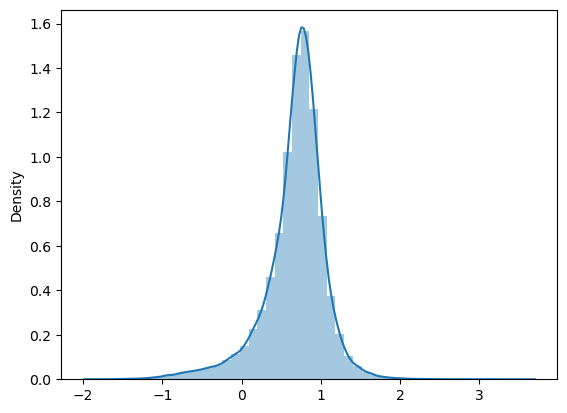

In [12]:
x = idata.posterior['n1_evidence_sd'].to_dataframe()

sns.distplot(x.xs('risky_first[T.True]',0, -1))

(x.xs('risky_first[T.True]',0, -1) < 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98088/993032765.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x.xs('risky_first[T.True]',0, -1))


n2_evidence_sd    0.916456
dtype: float64

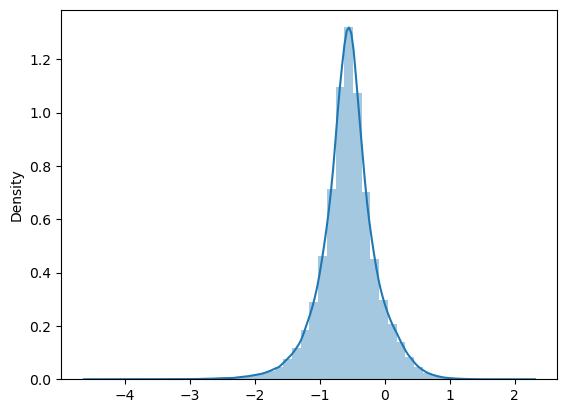

In [13]:
x = idata.posterior['n2_evidence_sd'].to_dataframe()

sns.distplot(x.xs('risky_first[T.True]',0, -1))

(x.xs('risky_first[T.True]',0, -1) < 0.0).mean()